# Table of contents
1. [Data preprocessing](#paragraph1)
    1. [Open the data file and study the general information](#subparagraph1)
    2. [Checking for data types](#subparagraph2)
    3. [Checking for missing values](#subparagraph3)
    4. [Checking for duplicates](#subparagraph4)
    5. [Conclusion](#subparagraph5)
2. [Exploratory Data Analysis](#paragraph2)
    1. [How many companies use our product every day, week, and month?](#subparagraph6)
    2. [What is the length of each session?](#subparagraph7)
    3. [Calculating revenue from calls](#subparagraph8)
    4. [Conclusion](#subparagraph9)
3. [Testing hypotheses](#paragraph3)
    1. [Conclusion](#subparagraph10)
4. [Prediction models](#paragraph4)
    1. [Conclusion](#subparagraph11)    
5. [Overall Conclusion](#paragraph5)

# Load, study and preprocess the data <a name="paragraph1"></a>

We import all our tools and the data, we check the data types and select the necessary columns to continue our analysis.

## Open the data files and study the general information <a name="subparagraph1"></a>

In [1]:
#!pip install missingno --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import datetime as dt

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, silhouette_score, roc_curve
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Import our dataset (there are two Excel files, description in README file).

LOCAL_PATH_1 = '~path/telecom_clients_us.csv '
PLATFORM_PATH_1 = '~path/telecom_clients_us.csv'

LOCAL_PATH_2 = '~path/telecom_dataset_us.csv '
PLATFORM_PATH_2 = '~path/telecom_dataset_us.csv'

try: 
    clients = pd.read_csv(LOCAL_PATH_1)
    data = pd.read_csv(LOCAL_PATH_2)
except:
    clients = pd.read_csv(PLATFORM_PATH_1)
    data = pd.read_csv(PLATFORM_PATH_2)

In [3]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [4]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [5]:
clients.describe()

,user_id
count,732.000000
mean,167431.927596
std,633.810383
min,166373.000000
25%,166900.750000
50%,167432.000000
75%,167973.000000
max,168606.000000


In [6]:
data.describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,53902.000000,45730.000000,53902.000000,53902.000000,53902.000000
mean,167295.344477,916535.993002,16.451245,866.684427,1157.133297
std,598.883775,21254.123136,62.917170,3731.791202,4403.468763
min,166377.000000,879896.000000,1.000000,0.000000,0.000000
25%,166782.000000,900788.000000,1.000000,0.000000,47.000000
50%,167162.000000,913938.000000,4.000000,38.000000,210.000000
75%,167819.000000,937708.000000,12.000000,572.000000,902.000000
max,168606.000000,973286.000000,4817.000000,144395.000000,166155.000000


## Checking for data types <a name="subparagraph2"></a>

After we have a 1st sight of our data, we will change the type from some of the variables in order to save memory usage. First we will check the type and then we will change into what we consider a more appropriate one.

In [7]:
data.info();
print()
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2

In [8]:
data = data.astype({
    'user_id': 'int32',
    'internal': 'bool',
    'operator_id': 'float32',
    'is_missed_call': 'bool',
    'calls_count': 'int32',
    'call_duration': 'int32',
    'total_call_duration': 'int32'
})

data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [9]:
clients = clients.astype({
    'user_id': 'int32',
    'tariff_plan': 'category',
})

clients['date_start'] = pd.to_datetime(clients['date_start'], format='%Y-%m-%d', utc=True)

We have changed our data types into more appropriate formats.

## Checking for missing values <a name="subparagraph3"></a>

We will check our two datasets for missing values. We see that `operator_id` is the only variable with so many missing values.

In [10]:
# Get a dataframe with the missing `operation_id` indeces
operator_id_missing  = data[data['operator_id'].isnull()]
print('The missing values for the operation_id column are {:.2%} of all our data.'.format(len(operator_id_missing)/len(data)))

The missing values for the operation_id column are 15.16% of all our data.


We can see that the missing values of `operator_id` can be categorised as Missing at random (MAR). We charge our clients in the scope if the call is internal or not and if it is outgoing or not, but not by which opetator made the call. Additionally, the NaN values in `operator_id` could be anyone from the already registered operators. As the operator is already in our dataset, our clients have already paid for them. Thus, the column `operator_id` can be filled with any `operator_id` for each customer.

So we will create the `filled` in order to be able to retain this information to calculate what each client pays for each operator.

In [11]:
# Fill NaNs with the bfill method which uses the next valid observation to fill the gap
data['filled_operator_id'] = data.groupby('user_id')['operator_id'].fillna(method='bfill')

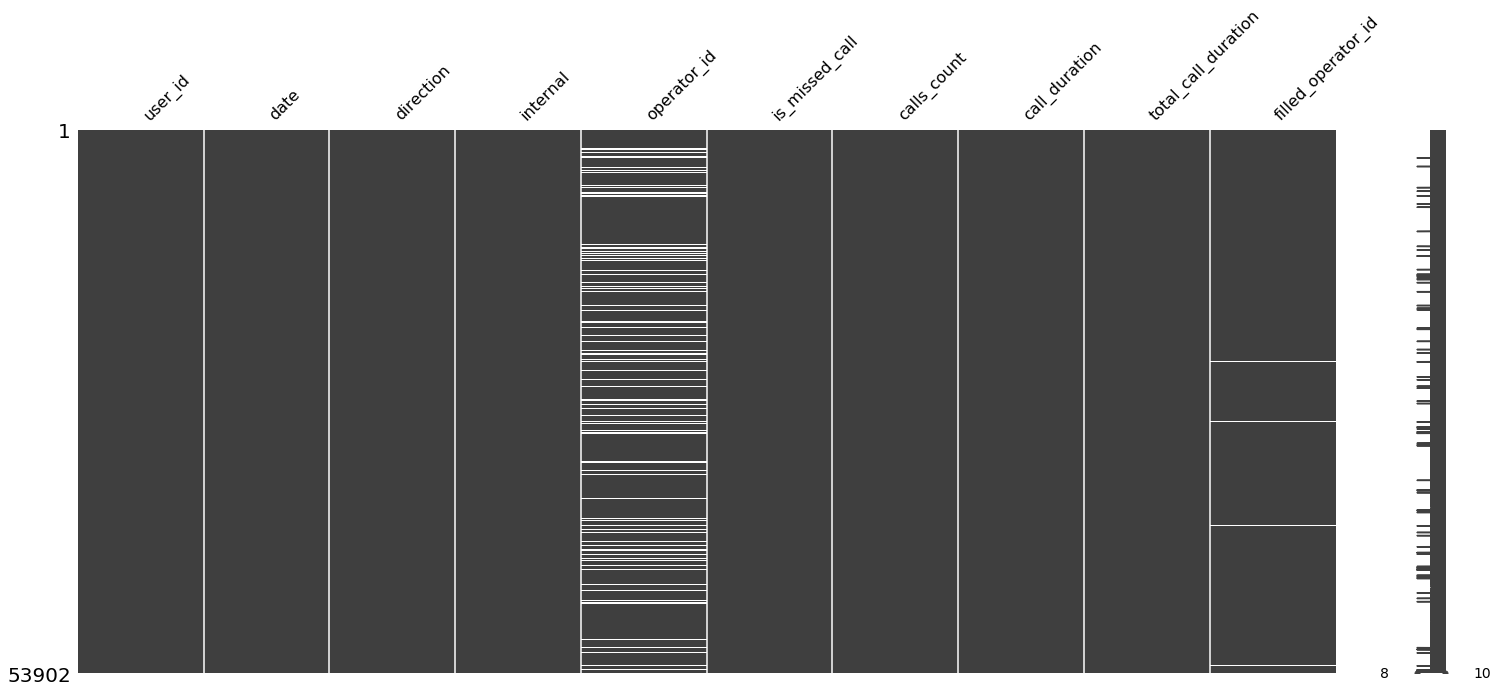

In [12]:
msno.matrix(data)

# Drop the operator_id column
data.drop('operator_id', axis=1, inplace=True)

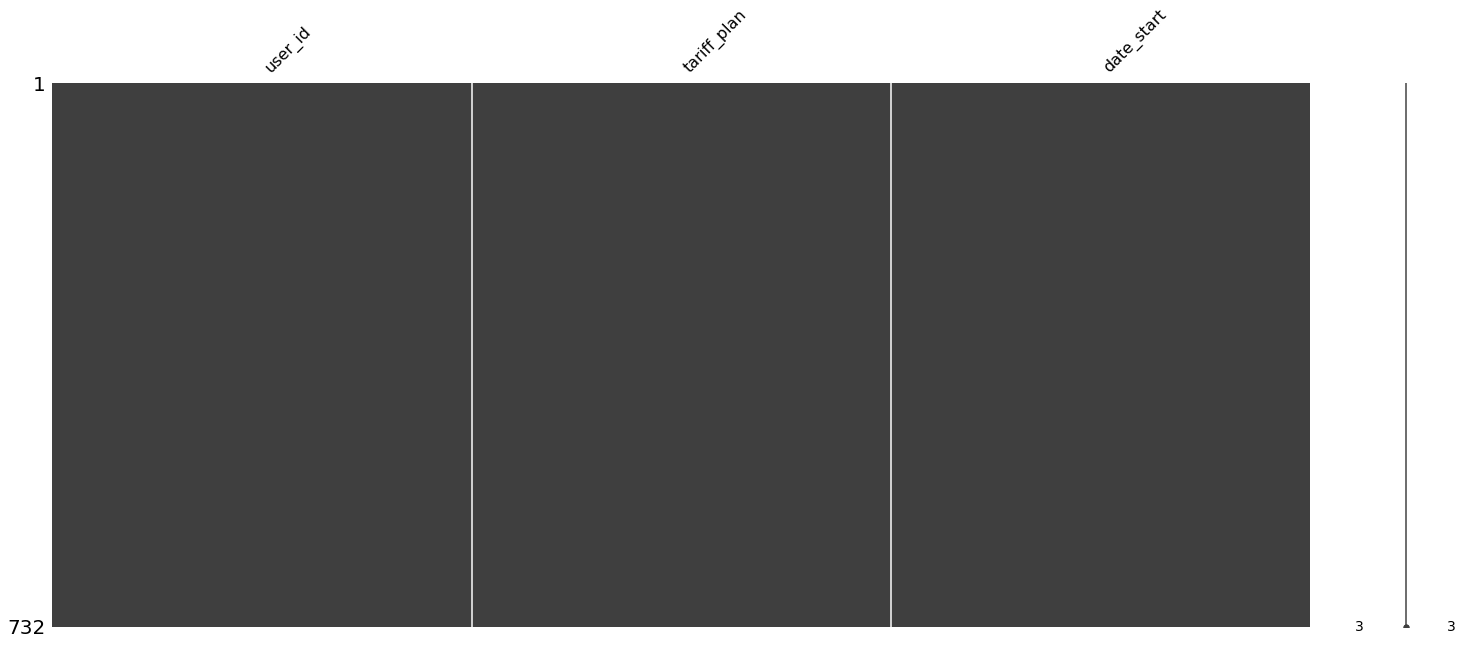

In [13]:
msno.matrix(clients)

The are no further missing data problems with our datasets.

## Checking for duplicates <a name="subparagraph4"></a>

After we removed NaNs, we check for duplicates in our dataset. Duplicates can give a false sense of how much call time each customer uses and artifficially inflate our revenue.

In [14]:
print('Number of duplicates for data dataset:', data.duplicated().sum())
print('Number of duplicates for clients dataset:', clients.duplicated().sum())

Number of duplicates for data dataset: 4676
Number of duplicates for clients dataset: 0


In [15]:
data = data.drop_duplicates()

In [16]:
data.info();
clients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49226 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype                                
---  ------               --------------  -----                                
 0   user_id              49226 non-null  int32                                
 1   date                 49226 non-null  datetime64[ns, pytz.FixedOffset(180)]
 2   direction            49226 non-null  object                               
 3   internal             49226 non-null  bool                                 
 4   is_missed_call       49226 non-null  bool                                 
 5   calls_count          49226 non-null  int32                                
 6   call_duration        49226 non-null  int32                                
 7   total_call_duration  49226 non-null  int32                                
 8   filled_operator_id   48789 non-null  float32                              
dtypes: bool

## Conclusion <a name="subparagraph5"></a>

- We changed data to more appropriate types to reduce memory.
- Data was 3.3+ MB and now is 1.6 MB, clients was 17.3+ KB and now is 9.5 KB.
- We have no remaing missing values and duplicates in each dataset.
- Missing values were MAR (Missing At Random) and therefore easy to fill (also missing values were way more than 5%-10% of data). As `operator_id` is essentially a category variable, we filled it's missing values with the mode.


# Exploratory Data Analysis <a name="paragraph2"></a>

Now that the data is ready to be analyzed, we will add some variables that will help us with the research.

## Daily, weekly and monthly usage of our product. <a name="subparagraph6"></a>

We will find how popular our service is. For doing this, we will create three additional columns in our `data` dataframe that captures (from `date`) when a company `user_id` used our service, each day, week and month. As a common practice, we will name this metrics as:

    DAU — the number of daily active (unique) users
    WAU — the number of weekly active users
    MAU — the number of monthly active users

In [17]:
data.head()

,user_id,date,direction,internal,is_missed_call,calls_count,call_duration,total_call_duration,filled_operator_id
0,166377,2019-08-04 00:00:00+03:00,in,False,True,2,0,4,880022.0
1,166377,2019-08-05 00:00:00+03:00,out,True,True,3,0,5,880022.0
2,166377,2019-08-05 00:00:00+03:00,out,True,True,1,0,1,880020.0
3,166377,2019-08-05 00:00:00+03:00,out,True,False,1,10,18,880020.0
4,166377,2019-08-05 00:00:00+03:00,out,False,True,3,0,25,880022.0


In [18]:
data['date_data'] = data['date'].dt.date
data['week'] = data['date'].dt.week
data['month'] = data['date'].dt.year.astype('str') + '-' + data['date'].dt.month.astype('str')

In [19]:
dau = data.groupby('date_data').agg({'user_id': 'nunique'})
wau = data.groupby('week').agg({'user_id': 'nunique'})
mau = data.groupby('month').agg({'user_id': 'nunique'})

print('On average, our product is used each day by {:.1f} users, each week by {:.1f} users and each month by {:.1f} users.'.format(dau.mean()[0],wau.mean()[0], mau.mean()[0]))

On average, our product is used each day by 87.3 users, each week by 142.8 users and each month by 198.0 users.


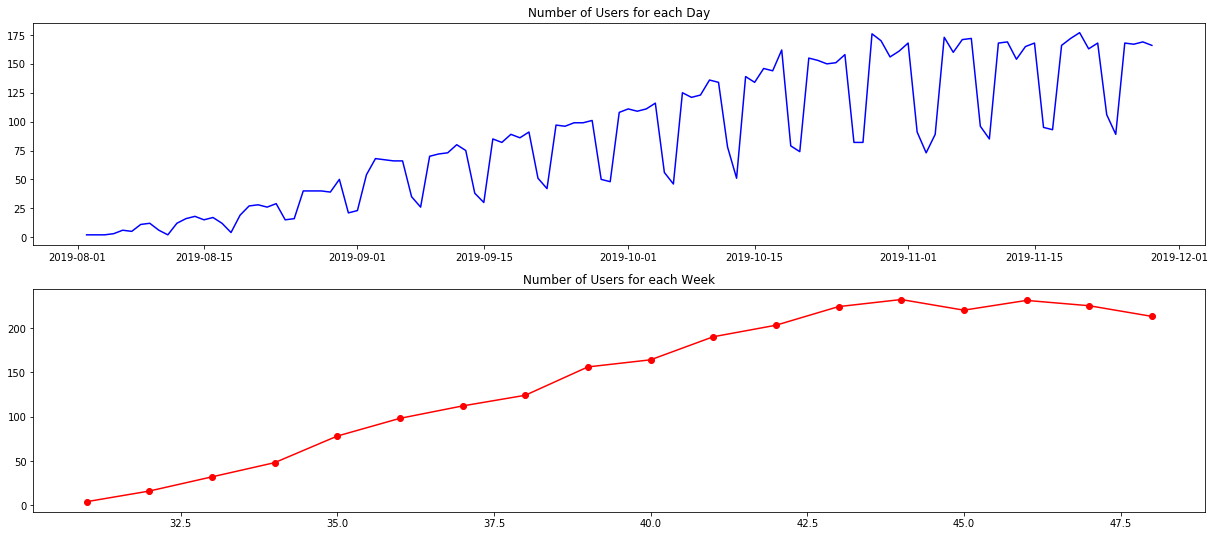

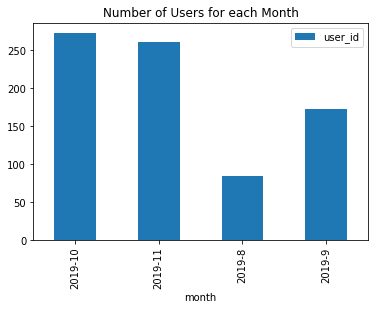

In [20]:
plt.figure(1, figsize=(21, 9))

plt.subplot(211)
plt.plot(dau, color='blue', linestyle='-', label='daily')
plt.title('Number of Users for each Day')

plt.subplot(212)
plt.plot(wau, color='red', marker='o', label='weekly')
plt.title('Number of Users for each Week')

mau.plot(kind='bar', label = 'C')
plt.title('Number of Users for each Month')
    
plt.show()

We can see an upward trend in the number of users from day 1. It seems, 90 days later, that the number is stabilized at around 175 daily and 270 monthly users.  

## Length of each session <a name="subparagraph7"></a>

count     49226.000000
mean       1153.281823
std        4443.456067
min           0.000000
25%          46.000000
50%         207.000000
75%         895.750000
max      166155.000000
Name: total_call_duration, dtype: float64


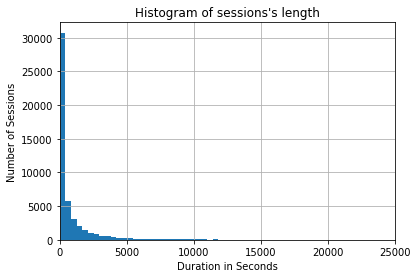

In [21]:
data['total_call_duration'].hist(bins='scott')
plt.xlim(0,25000)
plt.title('Histogram of sessions\'s length')
plt.xlabel('Duration in Seconds')
plt.ylabel('Number of Sessions')
print(data['total_call_duration'].describe())

We see that most sessions are below 7500 seconds something we confirm with the histogram. The average length of each session is 1153.28 seconds with a median of 207 seconds. As mean > median, high extreme values of duration distort our histogram. 75% percent of sessions are below 895.75 seconds, which is lower than a 1 std from the mean.

## 4C. Calculating revenue from calls <a name="subparagraph8"></a>

In order to analyze the revenue that generated by customers, we have to combine the customer data included in the `data` dataset with tarif plans in `clients` dataset. We will merge the two datasets on `user_id` as below. We will then split our dataset for each plan in order to calculate the total revenue from them.

In [22]:
data.head()

,user_id,date,direction,internal,is_missed_call,calls_count,call_duration,total_call_duration,filled_operator_id,date_data,week,month
0,166377,2019-08-04 00:00:00+03:00,in,False,True,2,0,4,880022.0,2019-08-04,31,2019-8
1,166377,2019-08-05 00:00:00+03:00,out,True,True,3,0,5,880022.0,2019-08-05,32,2019-8
2,166377,2019-08-05 00:00:00+03:00,out,True,True,1,0,1,880020.0,2019-08-05,32,2019-8
3,166377,2019-08-05 00:00:00+03:00,out,True,False,1,10,18,880020.0,2019-08-05,32,2019-8
4,166377,2019-08-05 00:00:00+03:00,out,False,True,3,0,25,880022.0,2019-08-05,32,2019-8


### Calculate each customer's call cost (according to his plan)

In [23]:
revenue = data.merge(clients, how='left', on='user_id')

# As incoming calls for all plans are free, we need to isolate only outgoing calls (either internal or external)
revenue_tariff_plan_A = revenue.query('tariff_plan == "A" & direction == "out"')
revenue_tariff_plan_B = revenue.query('tariff_plan == "B" & direction == "out"')
revenue_tariff_plan_C = revenue.query('tariff_plan == "C" & direction == "out"')

tariff_A_customers = revenue_tariff_plan_A.groupby(['user_id','internal'])['total_call_duration'].sum().reset_index()
tariff_B_customers = revenue_tariff_plan_B.groupby(['user_id','internal'])['total_call_duration'].sum().reset_index()
tariff_C_customers = revenue_tariff_plan_C.groupby(['user_id','internal'])['total_call_duration'].sum().reset_index()

# Calculate for each customer the excess_cost of its internal and external calls
tariff_A_customers['internal_excess_cost'] = (tariff_A_customers[tariff_A_customers['internal'] == True]['total_call_duration'] - 2000)*0.1
tariff_A_customers['external_cost'] = (tariff_A_customers[tariff_A_customers['internal'] == False]['total_call_duration'])*0.4

tariff_B_customers['internal_excess_cost'] = (tariff_B_customers[tariff_B_customers['internal'] == True]['total_call_duration'] - 2000)*0.15
tariff_B_customers['external_cost'] = (tariff_B_customers[tariff_B_customers['internal'] == False]['total_call_duration'])*0.5

tariff_C_customers['internal_excess_cost'] = (tariff_C_customers[tariff_C_customers['internal'] == True]['total_call_duration'] - 2000)*0.3
tariff_C_customers['external_cost'] = (tariff_C_customers[tariff_C_customers['internal'] == False]['total_call_duration'])*0.7

# Fill missing values of the new columns and remove negative costs
tariff_A_customers['internal_excess_cost'] = tariff_A_customers['internal_excess_cost'].fillna(0)
tariff_A_customers['external_cost'] = tariff_A_customers['external_cost'].fillna(0)
tariff_A_customers = tariff_A_customers.clip(lower=0)

tariff_B_customers['internal_excess_cost'] = tariff_B_customers['internal_excess_cost'].fillna(0)
tariff_B_customers['external_cost'] = tariff_B_customers['external_cost'].fillna(0)
tariff_B_customers = tariff_B_customers.clip(lower=0)

tariff_C_customers['internal_excess_cost'] = tariff_C_customers['internal_excess_cost'].fillna(0)
tariff_C_customers['external_cost'] = tariff_C_customers['external_cost'].fillna(0)
tariff_C_customers = tariff_C_customers.clip(lower=0)

# Calculate call cost for each type of call
tariff_A_customers['call_cost'] = tariff_A_customers['internal_excess_cost'] + tariff_A_customers['external_cost']
tariff_B_customers['call_cost'] = tariff_B_customers['internal_excess_cost'] + tariff_B_customers['external_cost'] 
tariff_C_customers['call_cost'] = tariff_C_customers['internal_excess_cost'] + tariff_C_customers['external_cost'] 


### Calculate each customer's operators' base cost

Clients pay 100 units for each operator (irrespectiv of plan).

In [24]:
base_revenue = data.groupby('user_id')['filled_operator_id'].nunique().reset_index()
base_revenue = base_revenue.rename(columns={'filled_operator_id': 'n_operators'})
base_revenue['revenue_of_operators'] = base_revenue['n_operators'] * 100
base_revenue.head()

,user_id,n_operators,revenue_of_operators
0,166377,5,500
1,166391,2,200
2,166392,3,300
3,166399,1,100
4,166405,10,1000


In [25]:
# Calculate total call cost
tariff_A_customers_total_revenue = tariff_A_customers.groupby(by = 'user_id')['call_cost'].sum().reset_index()
tariff_B_customers_total_revenue = tariff_B_customers.groupby(by = 'user_id')['call_cost'].sum().reset_index()
tariff_C_customers_total_revenue = tariff_C_customers.groupby(by = 'user_id')['call_cost'].sum().reset_index()

### Calculate each customer's total (call + base) cost

In [26]:
tariff_A_customers_total_revenue = tariff_A_customers_total_revenue.merge(base_revenue, how='left', on='user_id')
tariff_B_customers_total_revenue = tariff_B_customers_total_revenue.merge(base_revenue, how='left', on='user_id')
tariff_C_customers_total_revenue = tariff_C_customers_total_revenue.merge(base_revenue, how='left', on='user_id')

tariff_A_customers_total_revenue['total_cost'] = tariff_A_customers_total_revenue['revenue_of_operators'] + tariff_A_customers_total_revenue['call_cost'] + 5000
tariff_B_customers_total_revenue['total_cost'] = tariff_B_customers_total_revenue['revenue_of_operators'] + tariff_B_customers_total_revenue['call_cost'] + 2000
tariff_C_customers_total_revenue['total_cost'] = tariff_C_customers_total_revenue['revenue_of_operators'] + tariff_C_customers_total_revenue['call_cost'] + 1000

### Calculate each customer's hypothetical cost if he switches to other plan

#### Customers of Plan A (hypothetical switch to Plan B or C)

In [27]:
tariff_A_customers['internal_excess_cost_if_B'] = (tariff_A_customers[tariff_A_customers['internal'] == True]['total_call_duration'] - 2000)*0.15
tariff_A_customers['internal_excess_cost_if_C'] = (tariff_A_customers[tariff_A_customers['internal'] == True]['total_call_duration'] - 2000)*0.3

tariff_A_customers['external_cost_if_B'] = (tariff_A_customers[tariff_A_customers['internal'] == False]['total_call_duration'])*0.5
tariff_A_customers['external_cost_if_C'] = (tariff_A_customers[tariff_A_customers['internal'] == False]['total_call_duration'])*0.7

# Fill missing values of the new columns and remove negative costs
tariff_A_customers['internal_excess_cost_if_B'] = tariff_A_customers['internal_excess_cost_if_B'].fillna(0)
tariff_A_customers['internal_excess_cost_if_C'] = tariff_A_customers['internal_excess_cost_if_C'].fillna(0)

tariff_A_customers['external_cost_if_B'] = tariff_A_customers['external_cost_if_B'].fillna(0)
tariff_A_customers['external_cost_if_C'] = tariff_A_customers['external_cost_if_C'].fillna(0)

tariff_A_customers = tariff_A_customers.clip(lower=0)

# Calculate call cost for each type of call
tariff_A_customers['call_cost_if_B'] = tariff_A_customers['internal_excess_cost_if_B'] + tariff_A_customers['external_cost_if_B']
tariff_A_customers['call_cost_if_C'] = tariff_A_customers['internal_excess_cost_if_C'] + tariff_A_customers['external_cost_if_C']


tariff_A_customers_total_revenue_if_B = tariff_A_customers.groupby(by = 'user_id')['call_cost_if_B'].sum().reset_index()
tariff_A_customers_total_revenue_if_B = tariff_A_customers_total_revenue_if_B.merge(base_revenue, how='left', on='user_id')
tariff_A_customers_total_revenue_if_B['total_cost_if_B'] = tariff_A_customers_total_revenue_if_B['revenue_of_operators'] + tariff_A_customers_total_revenue_if_B['call_cost_if_B'] + 2000


tariff_A_customers_total_revenue_if_C = tariff_A_customers.groupby(by = 'user_id')['call_cost_if_C'].sum().reset_index()
tariff_A_customers_total_revenue_if_C = tariff_A_customers_total_revenue_if_C.merge(base_revenue, how='left', on='user_id')
tariff_A_customers_total_revenue_if_C['total_cost_if_C'] = tariff_A_customers_total_revenue_if_C['revenue_of_operators'] + tariff_A_customers_total_revenue_if_C['call_cost_if_C'] + 1000


#### Customers of Plan B (hypothetical switch to Plan A or C)

In [28]:
tariff_B_customers['internal_excess_cost_if_A'] = (tariff_B_customers[tariff_B_customers['internal'] == True]['total_call_duration'] - 2000)*0.1
tariff_B_customers['internal_excess_cost_if_C'] = (tariff_B_customers[tariff_B_customers['internal'] == True]['total_call_duration'] - 2000)*0.3

tariff_B_customers['external_cost_if_A'] = (tariff_B_customers[tariff_B_customers['internal'] == False]['total_call_duration'])*0.4
tariff_B_customers['external_cost_if_C'] = (tariff_B_customers[tariff_B_customers['internal'] == False]['total_call_duration'])*0.7

# Fill missing values of the new columns and remove negative costs
tariff_B_customers['internal_excess_cost_if_A'] = tariff_B_customers['internal_excess_cost_if_A'].fillna(0)
tariff_B_customers['internal_excess_cost_if_C'] = tariff_B_customers['internal_excess_cost_if_C'].fillna(0)

tariff_B_customers['external_cost_if_A'] = tariff_B_customers['external_cost_if_A'].fillna(0)
tariff_B_customers['external_cost_if_C'] = tariff_B_customers['external_cost_if_C'].fillna(0)

tariff_B_customers = tariff_B_customers.clip(lower=0)

# Calculate call cost for each type of call
tariff_B_customers['call_cost_if_A'] = tariff_B_customers['internal_excess_cost_if_A'] + tariff_B_customers['external_cost_if_A']
tariff_B_customers['call_cost_if_C'] = tariff_B_customers['internal_excess_cost_if_C'] + tariff_B_customers['external_cost_if_C']


tariff_B_customers_total_revenue_if_A = tariff_B_customers.groupby(by = 'user_id')['call_cost_if_A'].sum().reset_index()
tariff_B_customers_total_revenue_if_A = tariff_B_customers_total_revenue_if_A.merge(base_revenue, how='left', on='user_id')
tariff_B_customers_total_revenue_if_A['total_cost_if_A'] = tariff_B_customers_total_revenue_if_A['revenue_of_operators'] + tariff_B_customers_total_revenue_if_A['call_cost_if_A'] + 5000


tariff_B_customers_total_revenue_if_C = tariff_B_customers.groupby(by = 'user_id')['call_cost_if_C'].sum().reset_index()
tariff_B_customers_total_revenue_if_C = tariff_B_customers_total_revenue_if_C.merge(base_revenue, how='left', on='user_id')
tariff_B_customers_total_revenue_if_C['total_cost_if_C'] = tariff_B_customers_total_revenue_if_C['revenue_of_operators'] + tariff_B_customers_total_revenue_if_C['call_cost_if_C'] + 1000


#### Customers of Plan C (hypothetical switch to Plan A or B)

In [29]:
tariff_C_customers['internal_excess_cost_if_A'] = (tariff_C_customers[tariff_C_customers['internal'] == True]['total_call_duration'] - 2000)*0.1
tariff_C_customers['internal_excess_cost_if_B'] = (tariff_C_customers[tariff_C_customers['internal'] == True]['total_call_duration'] - 2000)*0.15

tariff_C_customers['external_cost_if_A'] = (tariff_C_customers[tariff_C_customers['internal'] == False]['total_call_duration'])*0.4
tariff_C_customers['external_cost_if_B'] = (tariff_C_customers[tariff_C_customers['internal'] == False]['total_call_duration'])*0.5

# Fill missing values of the new columns and remove negative costs
tariff_C_customers['internal_excess_cost_if_A'] = tariff_C_customers['internal_excess_cost_if_A'].fillna(0)
tariff_C_customers['internal_excess_cost_if_B'] = tariff_C_customers['internal_excess_cost_if_B'].fillna(0)

tariff_C_customers['external_cost_if_A'] = tariff_C_customers['external_cost_if_A'].fillna(0)
tariff_C_customers['external_cost_if_B'] = tariff_C_customers['external_cost_if_B'].fillna(0)

tariff_C_customers = tariff_C_customers.clip(lower=0)

# Calculate call cost for each type of call
tariff_C_customers['call_cost_if_A'] = tariff_C_customers['internal_excess_cost_if_A'] + tariff_C_customers['external_cost_if_A']
tariff_C_customers['call_cost_if_B'] = tariff_C_customers['internal_excess_cost_if_B'] + tariff_C_customers['external_cost_if_B']


tariff_C_customers_total_revenue_if_A = tariff_C_customers.groupby(by = 'user_id')['call_cost_if_A'].sum().reset_index()
tariff_C_customers_total_revenue_if_A = tariff_C_customers_total_revenue_if_A.merge(base_revenue, how='left', on='user_id')
tariff_C_customers_total_revenue_if_A['total_cost_if_A'] = tariff_C_customers_total_revenue_if_A['revenue_of_operators'] + tariff_C_customers_total_revenue_if_A['call_cost_if_A'] + 5000


tariff_C_customers_total_revenue_if_B = tariff_C_customers.groupby(by = 'user_id')['call_cost_if_B'].sum().reset_index()
tariff_C_customers_total_revenue_if_B = tariff_C_customers_total_revenue_if_B.merge(base_revenue, how='left', on='user_id')
tariff_C_customers_total_revenue_if_B['total_cost_if_B'] = tariff_C_customers_total_revenue_if_B['revenue_of_operators'] + tariff_C_customers_total_revenue_if_B['call_cost_if_B'] + 2000


### Calculate each customer's hypothetical savings if he switches to another plan.

We have added the variable `switch`, which takes the value 1 if savings are positive, meaning that a customer has a profit to switch into another plan. (So they overpay for their current plans)

In [30]:
tariff_A_customers_all = [tariff_A_customers_total_revenue['user_id'], tariff_A_customers_total_revenue['total_cost'], tariff_A_customers_total_revenue_if_B['total_cost_if_B'],
                         tariff_A_customers_total_revenue_if_C['total_cost_if_C']]

headers_A = ["user_id", "total_cost", "total_cost_if_B", "total_cost_if_C"]

tariff_A_customers_all_df = pd.concat(tariff_A_customers_all, axis=1, keys=headers_A)
tariff_A_customers_all_df = tariff_A_customers_all_df.set_index('user_id')


tariff_A_customers_all_df['save_if_B'] = tariff_A_customers_all_df['total_cost'] - tariff_A_customers_all_df['total_cost_if_B']
tariff_A_customers_all_df['save_if_C'] = tariff_A_customers_all_df['total_cost'] - tariff_A_customers_all_df['total_cost_if_C']

In [31]:
tariff_B_customers_all = [tariff_B_customers_total_revenue['user_id'], tariff_B_customers_total_revenue['total_cost'], tariff_B_customers_total_revenue_if_A['total_cost_if_A'],
                         tariff_B_customers_total_revenue_if_C['total_cost_if_C']]

headers_B = ["user_id", "total_cost", "total_cost_if_A", "total_cost_if_C"]

tariff_B_customers_all_df = pd.concat(tariff_B_customers_all, axis=1, keys=headers_B)
tariff_B_customers_all_df = tariff_B_customers_all_df.set_index('user_id')

tariff_B_customers_all_df['save_if_A'] = tariff_B_customers_all_df['total_cost'] - tariff_B_customers_all_df['total_cost_if_A']
tariff_B_customers_all_df['save_if_C'] = tariff_B_customers_all_df['total_cost'] - tariff_B_customers_all_df['total_cost_if_C']

In [32]:
tariff_C_customers_all = [tariff_C_customers_total_revenue['user_id'], tariff_C_customers_total_revenue['total_cost'], tariff_C_customers_total_revenue_if_A['total_cost_if_A'],
                         tariff_C_customers_total_revenue_if_B['total_cost_if_B']]

headers_C = ["user_id", "total_cost", "total_cost_if_A", "total_cost_if_B"]

tariff_C_customers_all_df = pd.concat(tariff_C_customers_all, axis=1, keys=headers_C)
tariff_C_customers_all_df = tariff_C_customers_all_df.set_index('user_id')

tariff_C_customers_all_df['save_if_A'] = tariff_C_customers_all_df['total_cost'] - tariff_C_customers_all_df['total_cost_if_A']
tariff_C_customers_all_df['save_if_B'] = tariff_C_customers_all_df['total_cost'] - tariff_C_customers_all_df['total_cost_if_B']

In [33]:
condition_tariff_A = [
    (tariff_A_customers_all_df['save_if_B'] > 0) | (tariff_A_customers_all_df['save_if_C'] > 0)
]

condition_tariff_B = [
    (tariff_B_customers_all_df['save_if_A'] > 0) | (tariff_B_customers_all_df['save_if_C'] > 0)
]

condition_tariff_C = [
    (tariff_C_customers_all_df['save_if_A'] > 0) | (tariff_C_customers_all_df['save_if_B'] > 0)
]

# create a list of the values we want to assign for each condition
value = [1]

# create a new column and use np.select to assign values to it using our lists as arguments
tariff_A_customers_all_df['switch'] = np.select(condition_tariff_A, value)
tariff_B_customers_all_df['switch'] = np.select(condition_tariff_B, value)
tariff_C_customers_all_df['switch'] = np.select(condition_tariff_C, value)

In [34]:
tariff_A_customers_all_df.head()

,total_cost,total_cost_if_B,total_cost_if_C,save_if_B,save_if_C,switch
user_id,,,,,,
166407,16949.0,17237.1,23815.0,-288.1,-6866.0,0
166541,11307.6,9784.5,11738.3,1523.1,-430.7,1
166582,4635321.6,5789827.0,8103837.8,-1154505.4,-3468516.2,0
166609,9080.8,6976.0,7766.4,2104.8,1314.4,1
166713,5305.2,2331.5,1384.1,2973.7,3921.1,1


Text(0, 0.5, 'Density')

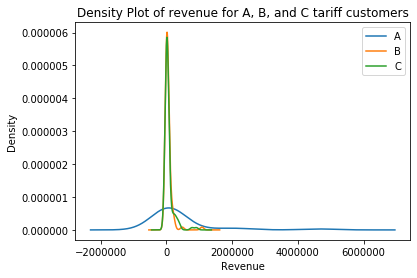

In [35]:
tariff_A_customers_total_revenue['total_cost'].plot(kind='density', label = 'A')
tariff_B_customers_total_revenue['total_cost'].plot(kind='density', label = 'B')
tariff_C_customers_total_revenue['total_cost'].plot(kind='density', label = 'C')

# Plot formatting
plt.legend()
plt.title('Density Plot of revenue for A, B, and C tariff customers')
plt.xlabel('Revenue')
plt.ylabel('Density')

The above density plot shows how different the revenue distributions between the plans are. We can infer that the means and variances abetween the plans are different, but we must make an statistic test to be certain (which we do in section 4. Test the hypotheses).

The density histogram above shows almost all values are from 0 to 125 for both plans, with very few above that value. The mean of both datasets is above the median (as confirmed from the describe() method) resulting a right skew density line. Overall, it does not seem that medians and standard deviations of the duration of the calls are different between the two plans. But if we want to compare for means we must follow up with a statistic test.

### Customers who need bigger plans

Customers from plan A can only switch to lower plans. Now we will find customers from plan B and C that is to their advantage to switch to a bigger plan. For example, below we can see customers that we should propose an upgrade to their plans.

In [36]:
tariff_B_customers_all_df.query('save_if_A > 0').head()

,total_cost,total_cost_if_A,total_cost_if_C,save_if_A,save_if_C,switch
user_id,,,,,,
166377,191727.5,156882.0,266418.5,34845.5,-74691.0,1
166405,480986.0,388388.8,671180.4,92597.2,-190194.4,1
166406,215267.5,175674.0,299454.5,39593.5,-84187.0,1
166485,228835.1,185815.2,321807.1,43019.9,-92972.0,1
166495,97942.5,81794.0,135239.5,16148.5,-37297.0,1


For the Plan C (lowest plan) customers, any of the other two plans is a bigger plan. So below we each customer that it saves him money to upgrade to any bigger plan.

In [37]:
 tariff_C_customers_all_df.query('save_if_A > 0 | save_if_B > 0').head()

,total_cost,total_cost_if_A,total_cost_if_B,save_if_A,save_if_B,switch
user_id,,,,,,
166487,5875.4,7828.8,5511.0,-1953.4,364.4,1
166511,373189.7,217808.4,267935.5,155381.3,105254.2,1
166520,250565.7,148380.4,180775.5,102185.3,69790.2,1
166619,4735.1,7177.2,4696.5,-2442.1,38.6,1
166677,17170.6,14283.2,13579.0,2887.4,3591.6,1


In [38]:
print('Number of customers that overpay {:.1f}.'.format(len(tariff_A_customers_all_df.query('switch == 1'))))
print('Number of customers that need bigger plans {:.1f}.'.format(
    len(tariff_B_customers_all_df.query('save_if_A > 0') +
    len( tariff_C_customers_all_df.query('save_if_A > 0 | save_if_B > 0')))))

Number of customers that overpay 9.0.
Number of customers that need bigger plans 37.0.


## Conclusion <a name="subparagraph9"></a>

In order to take a glimpse at whether or not a customer is satisfied, we should first calculate his cost at its current usage and how this usage translates into other plans. We found which customers overpay their plans (9 customers) and how many need bigger ones (37).

# Testing hypotheses <a name="paragraph3"></a>
We will now proceed with the testing hypotheses section. We will first check if our samples come from a normal distributed population in order to decide which tests we will use later.

### Shapiro Test for normally distributed populations

In [39]:
stat, p = st.shapiro(tariff_A_customers_total_revenue['total_cost'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Prob normal distribution (fail to reject H0)')
else:
    print('Prob NOT normal distribution (reject H0)')
    
print()   
stat, p = st.shapiro(tariff_B_customers_total_revenue['total_cost'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Prob normal distribution (fail to reject H0)')
else:
    print('Prob NOT normal distribution (reject H0)')
    
print()   
stat, p = st.shapiro(tariff_C_customers_total_revenue['total_cost'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Prob normal distribution (fail to reject H0)')
else:
    print('Prob NOT normal distribution (reject H0)')

Statistics=0.436, p=0.000
Prob NOT normal distribution (reject H0)

Statistics=0.378, p=0.000
Prob NOT normal distribution (reject H0)

Statistics=0.484, p=0.000
Prob NOT normal distribution (reject H0)


We can conclude that all three variables come from a population with NOT normal distribution. So we will use the Mann-Whitney U test for comparing independent data samples: the nonparametric version of the Student t-test.

### Mann-Whitney U non-parametric test for comparing means

Our 1st hypotheses is that the average revenue from users from differenent calling plans differs. The H0 is that the mean of revenue for tariff_A users is equal to the mean of revenue for tariff_B users.

    H0: μ(A) = μ(B)

    Ha: μ(A) != μ(B)

This is a two sided test and we we use the significance level of 5%.

In [40]:
print("{0:.5f}".format(st.mannwhitneyu(tariff_A_customers_total_revenue['total_cost'], tariff_B_customers_total_revenue['total_cost'])[1]))
# interpret
alpha = 0.05
if st.mannwhitneyu(tariff_A_customers_total_revenue['total_cost'], tariff_B_customers_total_revenue['total_cost'])[1] > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distributions between the two variables, so revenue differs from Group A to Group B. (reject H0)')

0.00284
Different distributions between the two variables, so revenue differs from Group A to Group B. (reject H0)


Our 2nd hypotheses is that the average revenue from users from differenent calling plans differs. The H0 is that the mean of revenue for tariff_A users is equal to the mean of revenue for tariff_C users.

    H0: μ(A) = μ(C)

    Ha: μ(A) != μ(C)

This is a two sided test and we we use the significance level of 5%.

In [41]:
print("{0:.5f}".format(st.mannwhitneyu(tariff_A_customers_total_revenue['total_cost'], tariff_C_customers_total_revenue['total_cost'])[1]))
# interpret
alpha = 0.05
if st.mannwhitneyu(tariff_A_customers_total_revenue['total_cost'], tariff_C_customers_total_revenue['total_cost'])[1] > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distributions between the two variables, so revenue differs from Group A to Group C. (reject H0)')

0.00062
Different distributions between the two variables, so revenue differs from Group A to Group C. (reject H0)


Our 3rd hypotheses is that the average revenue from users from differenent calling plans differs. The H0 is that the mean of revenue for tariff_B users is equal to the mean of revenue for tariff_C users.

    H0: μ(B) = μ(C)

    Ha: μ(B) != μ(C)

This is a two sided test and we we use the significance level of 5%.

In [42]:
print("{0:.5f}".format(st.mannwhitneyu(tariff_B_customers_total_revenue['total_cost'], tariff_C_customers_total_revenue['total_cost'])[1]))
# interpret
alpha = 0.05
if st.mannwhitneyu(tariff_B_customers_total_revenue['total_cost'], tariff_C_customers_total_revenue['total_cost'])[1] > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distributions between the two variables, so revenue differs from Group B to Group C. (reject H0)')

0.04141
Different distributions between the two variables, so revenue differs from Group B to Group C. (reject H0)


In [43]:
print('Percentage of current Plan A customers that are likely to change plan: {:.2%}.'.format(
     tariff_A_customers_all_df['switch'].sum() / len(tariff_A_customers_all_df['switch'])))

print('Percentage of current Plan B customers that are likely to change plan: {:.2%}.'.format(
     tariff_B_customers_all_df['switch'].sum() / len(tariff_B_customers_all_df['switch'])))

print('Percentage of current Plan C customers that are likely to change plan: {:.2%}.'.format(
      tariff_C_customers_all_df['switch'].sum() / len(tariff_C_customers_all_df['switch'])))

Percentage of current Plan A customers that are likely to change plan: 33.33%.
Percentage of current Plan B customers that are likely to change plan: 72.41%.
Percentage of current Plan C customers that are likely to change plan: 57.41%.


## 5A. Conclusion <a name="subparagraph10"></a>

In this section we have found that:
- samples are not normally distributed
- the average revenue from users of A, B and C calling plans do differ.
- the percentage of current Plan A, B and C customers that are likely to change plans is 33.33%, 72.41% and 57.41%
    
# Prediction models <a name="paragraph4"></a>

My thinking was that we aim to care about if a user will decide to switch or not. Using a Logistic Regression (as dependent variable is binary (switcher or not), I tried to make a model in order to evaluate how the independent variable `total_call_duration` and `internal` help us predict if a user will switch or not.

In [44]:
# define the function that will output our metrics
def print_all_metrics(y_true, y_pred, y_proba, title = 'Classification metrics'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

    #print(y_true, y_proba)

# define the function that takes each model and data as input and outputs metrics
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_probabilities = model.predict_proba(X_test)[:,1]
    print_all_metrics(y_test, y_pred, y_probabilities)
    
    # Plot the ROC curve of the probabilities of switch
    fallout, sensitivity, thresholds = roc_curve(np.ravel(y_test), y_probabilities)
    plt.plot(fallout, sensitivity, color = 'darkorange')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.show()

In [45]:
total_call_duration_by_user_id = data.groupby('user_id')['total_call_duration'].nunique()
internal_by_user_id = data.groupby('user_id')['internal'].count()
direction_by_user_id = data.loc[data['direction'] == 'out'].groupby('user_id').count()

In [46]:
y = pd.concat([tariff_A_customers_all_df['switch'], tariff_B_customers_all_df['switch'], tariff_C_customers_all_df['switch']], axis=0)


x = [total_call_duration_by_user_id[y.index], direction_by_user_id['direction'][y.index], internal_by_user_id[y.index]]
headers_x = ["total_call_duration", "n_outcals", "n_internals"]
X = pd.concat(x, axis=1, keys=headers_x)


In [47]:
# divide the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
Classification metrics
	Accuracy: 0.60
	Precision: 0.60
	Recall: 1.00
	F1: 0.75
	ROC_AUC: 0.65


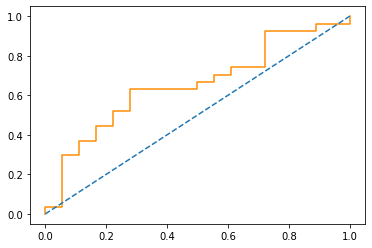

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Classification metrics
	Accuracy: 0.60
	Precision: 0.65
	Recall: 0.74
	F1: 0.69
	ROC_AUC: 0.69


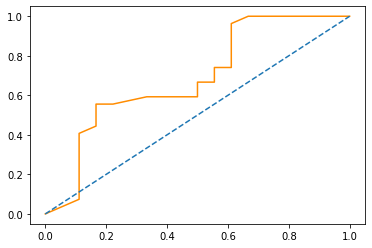

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Classification metrics
	Accuracy: 0.64
	Precision: 0.68
	Recall: 0.78
	F1: 0.72
	ROC_AUC: 0.74


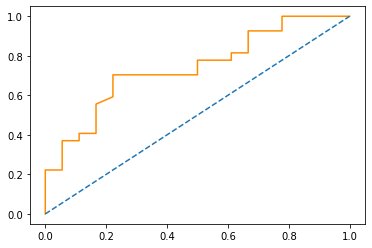

In [48]:
# create a StandardScaler object and apply it to the train set
scaler = StandardScaler() 
X_train_st = scaler.fit_transform(X_train) # train the scaler and transform the matrix for the train set

# apply standardization to the feature matrix for the test set
X_test_st = scaler.transform(X_test)

# declare the list of models
models = [LogisticRegression(random_state=0), RandomForestClassifier(n_estimators = 100, random_state = 0), GradientBoostingClassifier(n_estimators = 100, random_state = 0)]

# write a loop that outputs metrics for each model
for i in models:
    print(i) 
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

## Conclusion <a name="subparagraph11"></a>

We are using three different modelling techniques and our results are quite similar.

    Best Accuracy: GradientBoostingClassifier

    Best Precision: GradientBoostingClassifier

    Best Recall: LogisticRegression

    Best F1: LogisticRegression

    Best ROC_AUC: GradientBoostingClassifier

As accuracy only works when classes are balanced, we will not take it under consideration unless we stratify our samples. After that we can include accuracy and it points to the GradientBoostingClassifier model. As precision and recall are aimed at avoiding opposing risks, we need a harmonizing metric (F1 score) that takes into account the balance between the metrics. F1 points into a LogisticRegression model. AUC points to GradientBoostingClassifier. Notice that what the ROC chart shows us is the tradeoff between all values of our false positive rate (fallout) and true positive rate (sensitivity). If we had more variables (to act as independent variables) we could use these measures to compare between different models. Even as it is our model gives good classification results (better than random - the blue line).
 
# Overall conclusion <a name="paragraph5"></a>

_Final Findings_

1. There is an upward trend in the number of daily users. It peak at 175 users per day and it seems to be stabilizing.
2. Most calls are below 2 hours.
3. Our revenue comes from outcoming calls (especially externals).
4. For a customer, if switching to other plans is profitable, he is likely to see it too and change the company that he uses (us). We should be preemptive and know beforehand if those customers are not satisfied with their plans.
5. 9 customers overpay their plans and 37 need bigger ones.
6. Average revenue from users of A, B and C calling plans differs.
7. 33.33% of Plan A customers, 72.41% of Plan B and 57.41% of Plan C customers are likely to change plans.
8. A GradientBoostingClassifier model can predict better, than a simply random choice, if a customer falls in the `switch` category and he is dissatisfied and likely to leave.

_Recommendations_

1. Focus on external outcoming calls (prioritize them into the telecommunication network, give them better signal, etc.), as these generate the most income.
2. Carefully, optimize customers' plans (It is a better option than to lose them). Offering them more suitable plans, we keep them satisfied and maybe they can increase their usage of our network (mitigating the loss of revenue).